In [8]:
# write analog input onto DSC110 toptica scan
import sys
sys.path.append("..")
import nidaqmx
import numpy as np
import time
from LowLevelModules.bristol_wavelength_meter_client import *
from LowLevelModules.GeneralFunctions import *
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from pymeasure.instruments.thorlabs import ThorlabsPM100USB
from scipy.optimize import curve_fit

scan_terminal = '/Dev2/ao1'
offset_voltage = 0

from LowLevelModules.NIdaq import *
from pymeasure.instruments.thorlabs import ThorlabsPM100USB

def line(x,  a, b):
    return a*x+b

In [2]:
def toptica_bounded_write(v):
    """clamp the output voltage v [Volt] to be -5 <= v <= +5"""
    with nidaqmx.Task() as task_toptica:
        task_toptica.ao_channels.add_ao_voltage_chan(scan_terminal, 'Piezo scan', min_val=-5, max_val=5)
        vup = 5
        vdown = -5
        v_bound = max(  min(vup,v),vdown    )    
        task_toptica.write(v, auto_start=True, timeout=5) # write a single data    
        
def setupBristol(COM):
    """
    input - COM number
    set wavelength unit to nm-air, power unit to mW
    return wavemeter handle
    """
    bristol521handle=CLOpenUSBSerialDevice(COM)
    CLSetLambdaUnits(bristol521handle,'nm')
    CLSetPowerUnits(bristol521handle,'mw')
    CLSetMedium(bristol521handle,'air')
    return bristol521handle

def readBristol(handle):
    """
    return wavelength, power 
    """
    currentLambda = CLGetLambdaReading(handle)
    currentPower = CLGetPowerReading(handle)
    return currentLambda,currentPower

In [3]:
bristolCOM = 7

scan_terminal = '/Dev2/ao1' # laser scan
PM100Addr = 'USB0::0x1313::0x8078::P0021814::INSTR'

In [4]:
# PM = ThorlabsPM100USB(PM100Addr)

In [5]:
bristol521handle=CLOpenUSBSerialDevice(bristolCOM)

In [2]:
bristol521handle

1

In [2]:
from LowLevelModules.GeneralFunctions import *

In [5]:
from datetime import datetime

In [6]:
CLSetLambdaUnits(bristol521handle,'nm')
CLSetPowerUnits(bristol521handle,'mw')

In [15]:
CLSetPowerUnits(bristol521handle,'dB')

In [22]:
CLSetMedium(bristol521handle,'air')
currentLambda = CLGetLambdaReading(bristol521handle)
print(f'Wavelength (nm) = {currentLambda}')

CLSetMedium(bristol521handle,'vacuum')
currentLambda = CLGetLambdaReading(bristol521handle)
print(f'Wavelength (nm) = {currentLambda}')




Wavelength (nm) = 736.7850017503555
Wavelength (nm) = 736.9882849742884


In [18]:
currentLambda = CLGetLambdaReading(bristol521handle)
print(f'Wavelength (nm) = {currentLambda}')
currentPower = CLGetPowerReading(bristol521handle)
print(f'Bristol power (AU) = {currentPower}')

Wavelength (nm) = 736.9872070803005
Bristol power (AU) = 2.449816942214966


In [3]:
print(f'Power (mW) = {PM.measure_power(737)*1e6}')
currentLambda = CLGetLambdaReading(bristol521handle)
print(f'Wavelength (nm) = {currentLambda}')
currentPower = CLGetPowerReading(bristol521handle)
print(f'Bristol power (AU) = {currentPower}')

Power (mW) = 201.228206
Wavelength (nm) = 737.0594521838483
Bristol power (AU) = 2.819047689437866


<font size="10">Monitor wavelength</font>

<IPython.core.display.Javascript object>


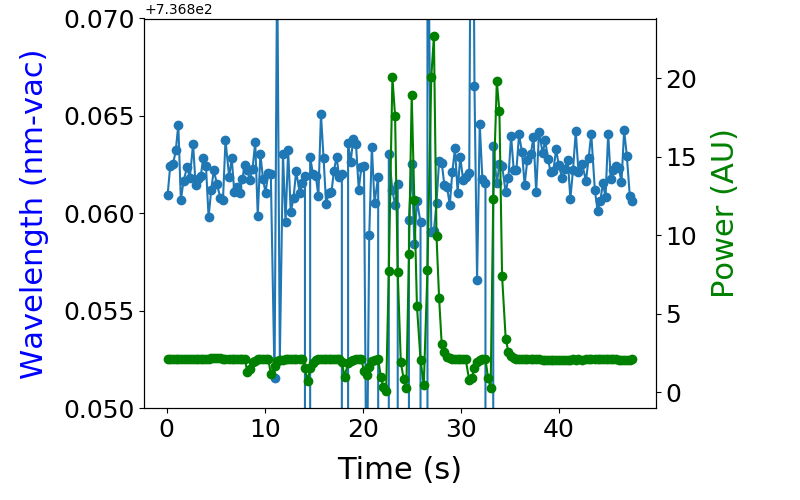

Exception


In [16]:
# voltage = np.linspace(0,2,40)
lambdalist=[]
powerlist=[]
t0 = []
timestep = 0.1 # sec
# volt_so_far=[]
i=0.0
lpLR = LivePlotLR(1, 1, 8, 5, 'o', 'Time (s)', 'Wavelength (nm-vac)','Power (AU)')
tinit = time.time()
while True:
    try:
        currentLambda = CLGetLambdaReading(bristol521handle)
        lambdalist.append(currentLambda)
        currentPower = CLGetPowerReading(bristol521handle)
        powerlist.append(currentPower)
        t0.append(time.time()-tinit)
        lpLR.plot_live(t0, lambdalist,powerlist)
        lpLR.ax1.set_ylim([736.85,736.87])
        time.sleep(timestep)
    except:
        print("Exception")
        break

In [35]:
max(lambdalist),min(lambdalist),max(lambdalist)-min(lambdalist)

(737.1879735922378, 737.0063511896354, 0.1816224026023292)

<font size="6">Scan piezo voltage</font>

In [26]:
task_toptica.write(-5, auto_start=True, timeout=5)

1

<IPython.core.display.Javascript object>


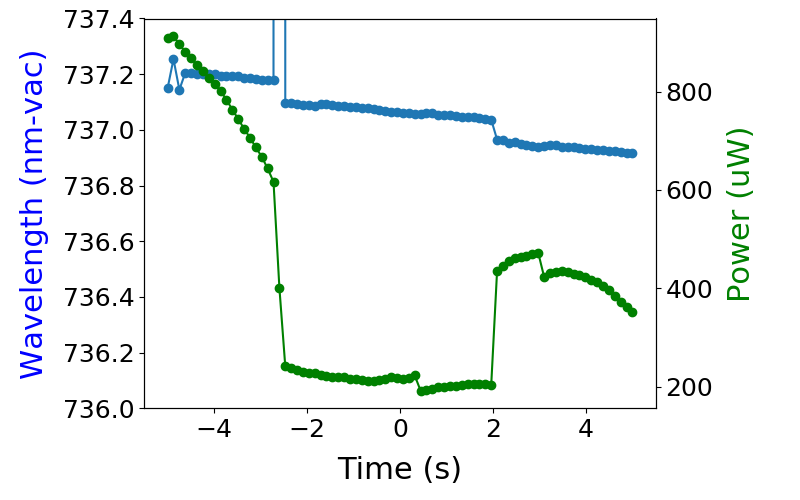

In [27]:
voltage = np.linspace(-5,5,80)
lambdalist=[]
powerlist=[]
# powermeterlist=[]
volt_so_far=[]

powerMeasSource = 'USB' # 'Bristol' or 'USB'

if powerMeasSource == 'Bristol':
    powerlabel = 'Power (AU)'
elif powerMeasSource == 'USB':
    powerlabel = 'Power (uW)'
else:
    powerlabel = ''

lpLR = LivePlotLR(1, 1, 8, 5, 'o', 'Time (s)', 'Wavelength (nm-vac)',powerlabel)

# lp.fig, lp.ax1 = plt.subplots(figsize=(10,5))

# lp.ax1.plot([],[],'bo-')
# lp.ax1.set_xlabel('Piezo control (V)',labelpad=10, fontsize=16)
# lp.ax1.set_ylabel('Wavelength (nm)', color='b',labelpad=10, fontsize=16)
# lp.ax2 = lp.ax1.twinx()
# lp.ax2.plot([],[],'go-')
# lp.ax2.set_ylabel('Power (uW)', color='g',labelpad=10, fontsize=16)

for v in voltage:
    task_toptica.write(v, auto_start=True, timeout=5)
    time.sleep(0.1)
    
    currentLambda = CLGetLambdaReading(bristol521handle)
    lambdalist.append(currentLambda)
    volt_so_far.append(v)
    
    if powerMeasSource == 'Bristol':
        currentPower = CLGetPowerReading(bristol521handle)
    elif powerMeasSource == 'USB':
        currentPower = PM.measure_power(737)*1e6
    else:
        currentPower = 0
    powerlist.append(currentPower)
    
#     currentPower = CLGetPowerReading(bristol521handle)
#     powerlist.append(currentPower)

#     currentPowerMeter = PM.measure_power(737)*1e6
#     powermeterlist.append(currentPowerMeter)  
    lpLR.plot_live(volt_so_far, lambdalist,powerlist)
#     lp.plot_live(volt_so_far, lambdalist)
    
#     lp.ax1.lines[0].set_xdata(volt_so_far)
#     lp.ax1.lines[0].set_ydata(lambdalist)
#     lp.ax2.lines[0].set_xdata(volt_so_far)
#     lp.ax2.lines[0].set_ydata(powermeterlist)
#     lp.ax1.set_ylim([736.5,737.4])
#     lp.ax2.relim()
#     lp.ax2.autoscale_view()
#     lp.fig.canvas.draw()
#     plt.tight_layout()    
#     lp2.plot_live(volt_so_far, powerlist)
    
#     lp3.plot_live(volt_so_far, powermeterlist)
    lpLR.ax1.set_ylim([736,737.4])
    
# end with 0 V
task_toptica.write(0, auto_start=True, timeout=5)

save_data = False
if save_data:
    data_type = 'TopticaScan'
    data_header=''
#     'after OD wheel, laser current (at 0V) (mA) = 62, feedforward =16 mA/full range (0 to 150 V) \npiezo control (V) wavelength(nm) power(uuW)'
    data_array = np.array([volt_so_far, lambdalist,powermeterlist]).T
    data_save(data_array, lp.fig, data_type, data_header)

In [16]:
lp.ax1.set_ylim([736.95,737.15])

(736.95, 737.15)

best_vals: [-1.47296896e-02  7.37138144e+02]
1.8987341772151898
-0.0279677650627444
616.5196540000001 880.764273 1.4286069670051427


<IPython.core.display.Javascript object>


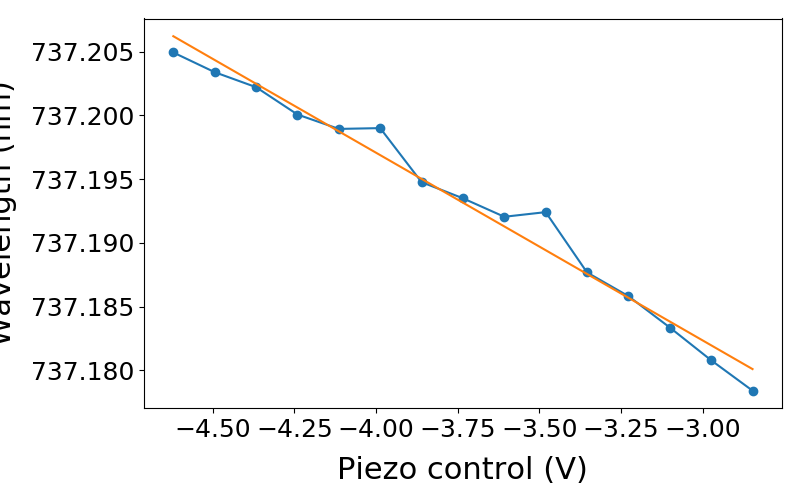

In [30]:
init_vals = [0.01,737]

xinit = 3
xfin = 18
best_vals, covar = curve_fit(line,voltage[xinit:xfin], lambdalist[xinit:xfin], p0=init_vals)
print('best_vals: {}'.format(best_vals))
print((voltage[xfin]-voltage[xinit])) 
print(best_vals[0]*(voltage[xfin]-voltage[xinit])) 
print(powerlist[xfin],powerlist[xinit],powerlist[xinit]/powerlist[xfin])
lpFit = LivePlot(1, 1, 8, 5, 'o', 'Piezo control (V)',"Wavelength (nm)")
lpFit.plot_live(voltage[xinit:xfin],lambdalist[xinit:xfin])
plt.plot(voltage[xinit:xfin], line(voltage[xinit:xfin], best_vals[0], best_vals[1]),
         label='Fitted function')
# lpFit.ax1.set_ylim([737.05,737.15])
